<h2 align="center" style="color:purple">Phase 2: AtliQ0 Bank Credit Card Project</h2>

### Business Analysis and launch of AB testing: Targeting Untapped Market

### Insights specific to customers with age group of 18 - 25
1. People with age group of 18 -25 accounts to ~25% of customer base in the data
2. Avg annual income of this age group is less than 50k
3. They don't have much credit history which is getting reflected in their credit score and max credit limit 
4. Usage of credit cards as payment type is relatively low compared to other groups
5. Avg transaction amount made with credit cards is also low compared to other groups
5. Top 3 most used shopping products categories  : Electronics, Fashion & Apparel, Beauty & Personal care

![Analysis Image](analysis.png)

## (1) Pre-Campaign

We want to do a trial run for our new credit card. For this we need to figure out (1) How many customers do we need for our A/B testing. We will form a control and test group. For both of these groups we can figure out number of customers we need based on the statistical power and effect size that we agree upon after discussing with business. We will use 

In [21]:
#import required libraries
import statsmodels.stats.api as sms
import statsmodels.api as sm
import pandas as pd
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt
import seaborn as sns

In [22]:
alpha = 0.05
power = 0.8
effect_size = 0.2

sms.tt_ind_solve_power(
    effect_size=0.2, 
    alpha=alpha, 
    power=power, 
    ratio=1, 
    alternative='two-sided'
)

393.4056989990335

For effect size 2 we need 393 customers. We have to keep in mind budgeting restrictions while running this campaign hence let us run this for different effect sizes and discuss with business to find out which sample size would be optimal

In [29]:
effect_sizes = [0.1, 0.2, 0.3, 0.4, 0.5,1]  #  standard deviations greater than control group 

for effect_size in effect_sizes:
    sample_size = sms.tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, ratio=1, alternative='two-sided')
    
    print(f"Effect Size: {effect_size}, Required Sample Size: {int(sample_size)} customers")

Effect Size: 0.1, Required Sample Size: 1570 customers
Effect Size: 0.2, Required Sample Size: 393 customers
Effect Size: 0.3, Required Sample Size: 175 customers
Effect Size: 0.4, Required Sample Size: 99 customers
Effect Size: 0.5, Required Sample Size: 63 customers
Effect Size: 1, Required Sample Size: 16 customers


Based on business requirements, the test should be capable of detecting a minimum 0.4 standard deviation difference between the control and test groups. For the effect size 0.4, we need 100 customers and when we discussed with business, 100 customers is ok in terms of their budgeting constraints for this trail run

#### Forming control and test groups

1.We have identified approximately 246 customers within the age group of 18 to 25. From this pool, we will select 100 customers for the initial campaign launch.

2.The campaign is launched for 100 customers, as determined by the effective size calculation and by considering budgeting costs, and will run campaign for a duration of 2 months

3.Got a conversion rate of ~40% ( implies 40 out of 100 customers in test group started using credit card)

4.To maintain a similar sample size, a control group consisting of 40 customers will be created. Importantly, this control group will be completely exclusive of initial 100 customers used as test group.

5.So now we have 40 customers in each of control and test groups

##### At the end of the 2-month campaign period (from 09-10-23 to 11-10-23), we obtained daily data showing the average transaction amounts made by the entire group of 40 customers in both the control and test groups using existing and newly launched credit cards respectively

##### The key performance indicator (KPI) for this AB test aims to enhance average transaction amounts facilitated by the new card

## (2) Post-Campaign

## Two Sample Z Test for Our Hypothesis Testing

In [31]:
# Loading campaign results data
df = pd.read_csv('data/avg_transactions_after_campaign.csv')
df.head(4)

,campaign_date,control_group_avg_tran,test_group_avg_tran
0,2023-09-10,259.83,277.32
1,2023-09-11,191.27,248.68
2,2023-09-12,212.41,286.61
3,2023-09-13,214.92,214.85


In [33]:
df.shape

(62, 3)

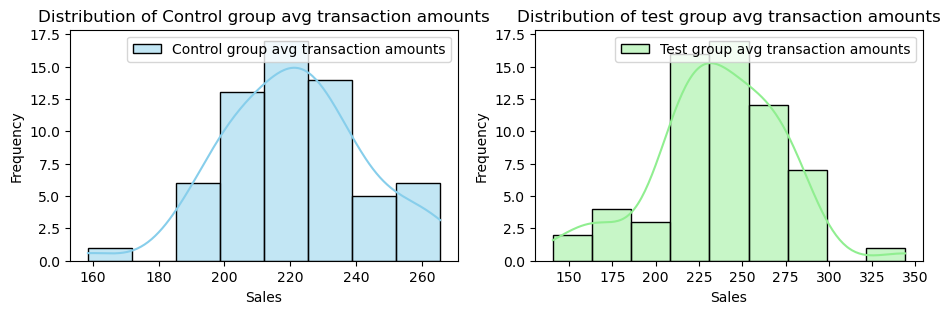

In [35]:
# Let's look at distributions of avg transactions amounts in both groups
# Create a 1x2 grid of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 3))

# Plot the distribution of Campaign A Sales
sns.histplot(df['control_group_avg_tran'], kde=True, color='skyblue', label='Control group avg transaction amounts', ax=ax1)
ax1.set_xlabel('Sales')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Control group avg transaction amounts')
ax1.legend()

# Plot the distribution of Campaign B Sales
sns.histplot(df['test_group_avg_tran'], kde=True, color='lightgreen', label='Test group avg transaction amounts', ax=ax2)
ax2.set_xlabel('Sales')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of test group avg transaction amounts')
ax2.legend()

# Show the plots
plt.show()

#### Perform Hypothesis Testing Using Two Sample Z-test

In [49]:
control_mean = df.control_group_avg_tran.mean()
control_std = df.control_group_avg_tran.std()

control_mean, control_std

(221.1751612903226, 21.359192112027014)

In [53]:
test_mean = df.test_group_avg_tran.mean()
test_std = df.test_group_avg_tran.std()

test_mean, test_std

(235.9835483870968, 36.65808210918637)

In [41]:
sample_size = df.shape[0]
sample_size

62

### Test Using Rejection Region (i.e. Critical Z Value)

In [55]:
a = (control_std**2/sample_size)
b = (test_std**2/sample_size)

z_score = (test_mean - control_mean) / np.sqrt(a + b)
z_score

2.7482973745691135

In [59]:
z_critical = st.norm.ppf(1 - alpha)
z_critical

1.6448536269514722

In [61]:
z_score > z_critical

True

Since Z score is higher than critical Z value, we can reject the null hypothesis.

### Test Using p-Value

In [65]:
# Calculate the p-value corresponding to z score for a right-tailed test
p_value = 1 - st.norm.cdf(z_score)
p_value

0.0029952824622024865

In [67]:
p_value < alpha # p value is less than significance level of 5% (or 0.05 for absolute value)

True

Since p value is less than significance level (i.e. alpha), we can reject the null hypothesis.

### Using Ready Made API call

1.We will now use stats module from statmodels for doing Z-test

2.The order of passing control and test group data to sm.stats.ztest(test_data, control_data) defines the direction of the test and influences the test results.

3.When you pass test group data first, z-test module assumes that alternative hypothesis as mean of the test group is greater than the mean of the control group and conversely if you switch the order z-test module assumes alternative hypothesis as control group average is more than test group 

4.In here we will be using order as sm.stats.ztest(test_group_data, control_group_data) based on our alternative hypothesis considered above.

5.By default z-test module in statmodels performs two tailed test. As we are doing one-tailed test in our case based on the direction and alternate hypothesis we have to set "alternative" parameter.

6.In out case based on test direction we will set "alternative" parameter to "larger"

#### How to choose right Alternative parameter

a.Two-tailed, meaning you are interested in identifying deviations across control and test groups in either direction 

b.larger, This is a one-tailed test, specifically looking for whether the first group is significantly larger than the second

c.smaller, This is another one-tailed test, specifically looking for whether the first group is significantly smaller than the second


![image.png](image.png)

You can check more details about this z-test module and paramteres in here
https://statsmodels.org/devel/generated/statsmodels.stats.weightstats.ztest.html

In [69]:
z_statistic, p_value = sm.stats.ztest(df['test_group_avg_tran'], df['control_group_avg_tran'], alternative = 'larger')
z_statistic, p_value

(2.7482973745691135, 0.002995282462202502)